In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
import pytensor.tensor as pt
import SBMMODELIMPROVED as model
import logging
import seaborn as sns
from scipy.stats import mode
import networkx as nx
import random  
import pytensor
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import xarray as xr
np.random.seed(42)
random.seed(42)
pytensor.config.default_rng = np.random.default_rng(42)  

In [3]:
df = pd.read_csv("simulacionx.csv", index_col=0)
data_matrix = df.to_numpy(dtype=int)
data_matrix = np.array(data_matrix, dtype=np.float64)
print(f"Tipo de data_matrix: {data_matrix.dtype}")
print(f"Forma de data_matrix: {data_matrix.shape}")

# ---------------------------- Hyperparameters --------------------------------------
num_blocks = 5
num_nodes = 50
a_alpha = 1  
b_alpha = 1  
mu_zeta = 0
sigma_zeta = 2  
a_tau = 2    
b_tau = 1    

Tipo de data_matrix: float64
Forma de data_matrix: (50, 50)


In [4]:
# ---------------------------- Create and Sample Model --------------------------------------
SBMmodel_improved = model.create_model_improved(
    data_matrix, 
    num_nodes=num_nodes, 
    num_blocks=num_blocks,
    a_alpha=a_alpha,
    b_alpha=b_alpha,
    a_tau=a_tau,
    b_tau=b_tau,
    mu_zeta=mu_zeta,
    sigma_zeta=sigma_zeta
)
with SBMmodel_improved:
    init = 'adapt_diag'
    trace = pm.sample(
        draws=20000,           
        tune=10000,            
        target_accept=0.97,   
        init=init,
        return_inferencedata=True,
        random_seed=42,
        chains=4,
        cores=2,
        idata_kwargs={"log_likelihood": True}
    )

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [alpha, omega, log_tau, zeta_raw, Theta_kl_logit]
>CategoricalGibbsMetropolis: [E_vector]


/opt/anaconda3/envs/aesara_env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 504 seconds.
/opt/anaconda3/envs/aesara_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


WAIC, AIC, BIC

In [5]:
waic_data = az.waic(trace)
print("WAIC object structure:")
print(waic_data)

log_likelihood = trace.log_likelihood.Y_obs.values
log_likelihood_sum = log_likelihood.sum()

n_chains = trace.posterior.sizes["chain"]
n_draws = trace.posterior.sizes["draw"]
k = n_chains * n_draws  
n = log_likelihood.shape[0] 

#  AIC y BIC
aic = -2 * log_likelihood_sum + 2 * k
bic = -2 * log_likelihood_sum + k * np.log(n)

try:
    waic_value = -2 * float(waic_data.elpd_waic)
except AttributeError:
    print("Available attributes:", dir(waic_data))
    waic_value = np.nan  

metrics_table = pd.DataFrame({
    "WAIC": [waic_value],
    "AIC": [aic], 
    "BIC": [bic]
})

print("\nInformation Criteria Metrics:")
print(metrics_table)

WAIC object structure:
Computed from 80000 posterior samples and 1225 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -380.50    22.72
p_waic       15.73        -

Information Criteria Metrics:
         WAIC           AIC           BIC
0  760.990319  5.972875e+07  5.967966e+07


INCIDENCE MATRIX

Adjusted Rand Index: 0.6315
Normalized Mutual Information: 0.7938

Bloque Assignments Summary:
Block 1: 16 nodes - [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 31, 33, 34, 35, 39, 40]
Block 2: 18 nodes - [11, 12, 13, 14, 15, 16, 17, 18, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Block 3: 4 nodes - [32, 36, 37, 38]
Block 4: 12 nodes - [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


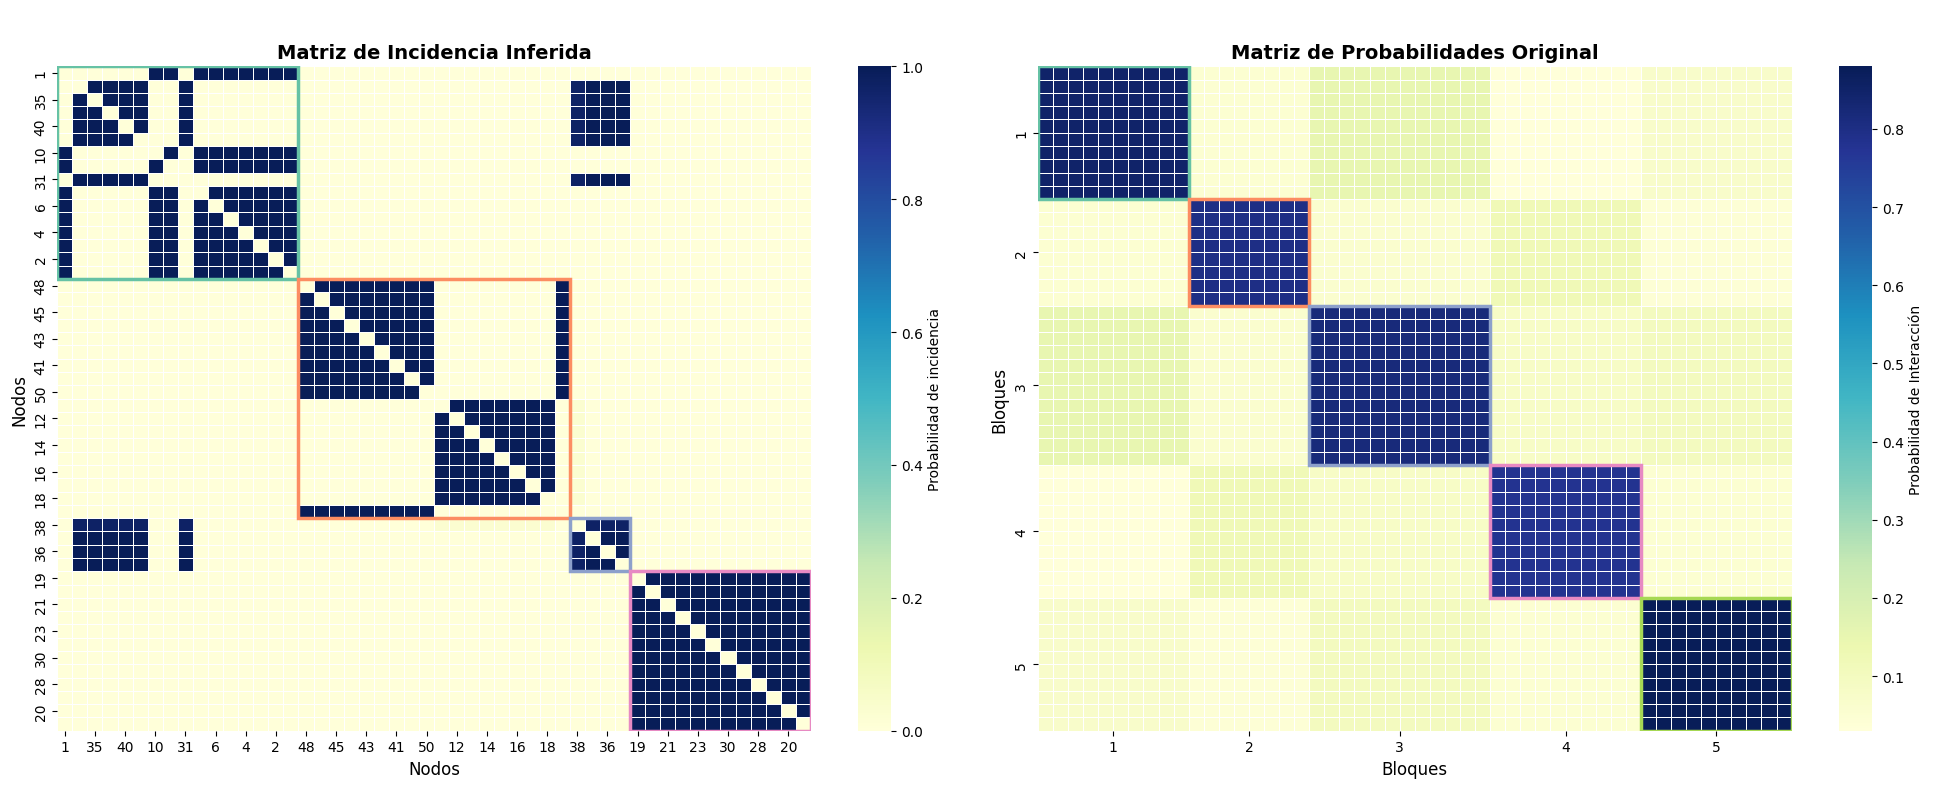

In [7]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
# Original probability matrix 
original_prob_matrix = np.array([
    [0.85, 0.05, 0.15, 0.03, 0.07],
    [0.05, 0.80, 0.06, 0.12, 0.04],
    [0.15, 0.06, 0.82, 0.08, 0.10],
    [0.03, 0.12, 0.08, 0.78, 0.05],
    [0.07, 0.04, 0.10, 0.05, 0.88]
])
n_nodos = 50
proporciones = np.array([0.2, 0.15, 0.25, 0.2, 0.2])
nodos_por_bloque = np.round(proporciones * n_nodos).astype(int)
if np.sum(nodos_por_bloque) != n_nodos:
    diferencia = n_nodos - np.sum(nodos_por_bloque)
    nodos_por_bloque[-1] += diferencia

# the true block assignment vector
true_assignments = np.zeros(n_nodos, dtype=int)
start_idx = 0
for block_idx, count in enumerate(nodos_por_bloque):
    true_assignments[start_idx:start_idx+count] = block_idx
    start_idx += count

# trace assignment vector 
E_samples = trace.posterior["E_vector"].values  
E_samples = E_samples.reshape(-1, 50)  # (total_samples, 50)
num_samples = E_samples.shape[0]
coincidence_matrices = np.zeros((num_samples, 50, 50), dtype=int)
for i in range(num_samples):
    sample = E_samples[i] 
    coincidence_matrices[i] = (sample[:, None] == sample[None, :]).astype(int)  
E_samples = E_samples.reshape(-1, E_samples.shape[-1])
num_samples, num_nodes = E_samples.shape
incidence_matrix_avg = np.zeros((num_nodes, num_nodes))
for sample in E_samples:
    order = np.argsort(sample)
    incidence_matrix = np.zeros((num_nodes, num_nodes))
    unique_labels = np.unique(sample)
    for label in unique_labels:
        members = np.where(sample == label)[0]  
        incidence_matrix[np.ix_(members, members)] = 1
    incidence_matrix = incidence_matrix[np.ix_(order, order)]
    incidence_matrix_avg += incidence_matrix
incidence_matrix_avg /= num_samples
incidence_matrix_rounded = np.round(incidence_matrix_avg, 2)

# mode function
def robust_mode(arr):
    unique, counts = np.unique(arr, return_counts=True)
    max_count = np.max(counts)
    candidates = unique[counts == max_count]  
    return np.min(candidates)  
    
num_blocks = np.max(E_samples) + 1  
E_modes = np.array([robust_mode(E_samples[:, i]) for i in range(num_nodes)])

unique_blocks = np.unique(E_modes)
block_mapping = {block: i for i, block in enumerate(unique_blocks)}
E_modes_mapped = np.array([block_mapping[b] for b in E_modes])

# Create incidence matrix
incidence_matrix = np.zeros((num_nodes, num_nodes))
for sample in E_samples:
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if sample[i] == sample[j]:  
                incidence_matrix[i, j] += 1
                incidence_matrix[j, i] += 1  

incidence_matrix /= E_samples.shape[0]
incidence_matrix_rounded = np.round(incidence_matrix, 2)

# Sort by the mapped block assignments
sorted_indices = np.argsort(E_modes_mapped)
incidence_matrix_sorted = incidence_matrix_rounded[np.ix_(sorted_indices, sorted_indices)]
df_sorted = pd.DataFrame(incidence_matrix_sorted, index=sorted_indices+1, columns=sorted_indices+1)

rand_score = adjusted_rand_score(true_assignments, E_modes_mapped)
nmi_score = normalized_mutual_info_score(true_assignments, E_modes_mapped)

print(f"Adjusted Rand Index: {rand_score:.4f}")
print(f"Normalized Mutual Information: {nmi_score:.4f}")

# Create a summary of node assignments to blocks
block_summary = {}
for block in range(len(unique_blocks)):
    nodes_in_block = np.where(E_modes_mapped == block)[0] + 1  
    block_summary[f"Block {block+1}"] = {
        "Nodes": nodes_in_block.tolist(),
        "Count": len(nodes_in_block)
    }

print("\nBloque Assignments Summary:")
for block, info in block_summary.items():
    print(f"{block}: {info['Count']} nodes - {info['Nodes']}")

def expand_probability_matrix(prob_matrix, block_sizes):
    """
    Expande una matriz de probabilidades entre bloques para mostrar el tamaño real de cada bloque.
    """
    K = len(block_sizes)
    total_nodes = sum(block_sizes)
    expanded_matrix = np.zeros((total_nodes, total_nodes))
    
    start_indices = np.zeros(K, dtype=int)
    for i in range(1, K):
        start_indices[i] = start_indices[i-1] + block_sizes[i-1]

    for i in range(K):
        for j in range(K):
            i_start, i_end = start_indices[i], start_indices[i] + block_sizes[i]
            j_start, j_end = start_indices[j], start_indices[j] + block_sizes[j]
            expanded_matrix[i_start:i_end, j_start:j_end] = prob_matrix[i, j]
    
    return expanded_matrix, start_indices

expanded_prob_matrix, start_indices = expand_probability_matrix(original_prob_matrix, nodos_por_bloque)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
elegant_cmap = sns.color_palette("YlGnBu", as_cmap=True)
sns.heatmap(df_sorted, cmap=elegant_cmap, cbar=True, 
            linewidths=0.5, linecolor='white', ax=axes[0],
            cbar_kws={'label': 'Probabilidad de incidencia'})
axes[0].set_title("Matriz de Incidencia Inferida", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Nodos", fontsize=12)
axes[0].set_ylabel("Nodos", fontsize=12)
axes[0].tick_params(labelsize=10)

sns.heatmap(expanded_prob_matrix, cmap=elegant_cmap, cbar=True, 
            linewidths=0.5, linecolor='white', ax=axes[1],
            cbar_kws={'label': 'Probabilidad de Interacción'})
axes[1].set_title("Matriz de Probabilidades Original", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Bloques", fontsize=12)
axes[1].set_ylabel("Bloques", fontsize=12)

orig_block_positions = []
for i in range(len(nodos_por_bloque)):
    block_mid = start_indices[i] + nodos_por_bloque[i] / 2
    orig_block_positions.append((block_mid, f"{i+1}"))  

axes[1].set_xticks([pos[0] for pos in orig_block_positions])
axes[1].set_xticklabels([pos[1] for pos in orig_block_positions])
axes[1].set_yticks([pos[0] for pos in orig_block_positions])
axes[1].set_yticklabels([pos[1] for pos in orig_block_positions])

current_pos = 0
num_blocks_inferred = len(unique_blocks)
elegant_boundary_palette = sns.color_palette("Set2", max(num_blocks_inferred, len(nodos_por_bloque)))

for block_idx in range(num_blocks_inferred):
    block_size = np.sum(E_modes_mapped[sorted_indices] == block_idx)
    if block_size > 0:
        axes[0].add_patch(plt.Rectangle((current_pos, current_pos), 
                                      block_size, block_size, 
                                      fill=False, edgecolor=elegant_boundary_palette[block_idx], 
                                      lw=2.5, linestyle='-'))
        current_pos += block_size

current_pos = 0
for block_idx, block_size in enumerate(nodos_por_bloque):
    if block_size > 0:
        axes[1].add_patch(plt.Rectangle((current_pos, current_pos), 
                                      block_size, block_size, 
                                      fill=False, edgecolor=elegant_boundary_palette[block_idx], 
                                      lw=2.5, linestyle='-'))
        current_pos += block_size

fig.suptitle(" ", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig("IncidSBM_Sim1.png", dpi=300, bbox_inches='tight')
plt.show()

LOG-LIKELIHOOD CONVERGENCE

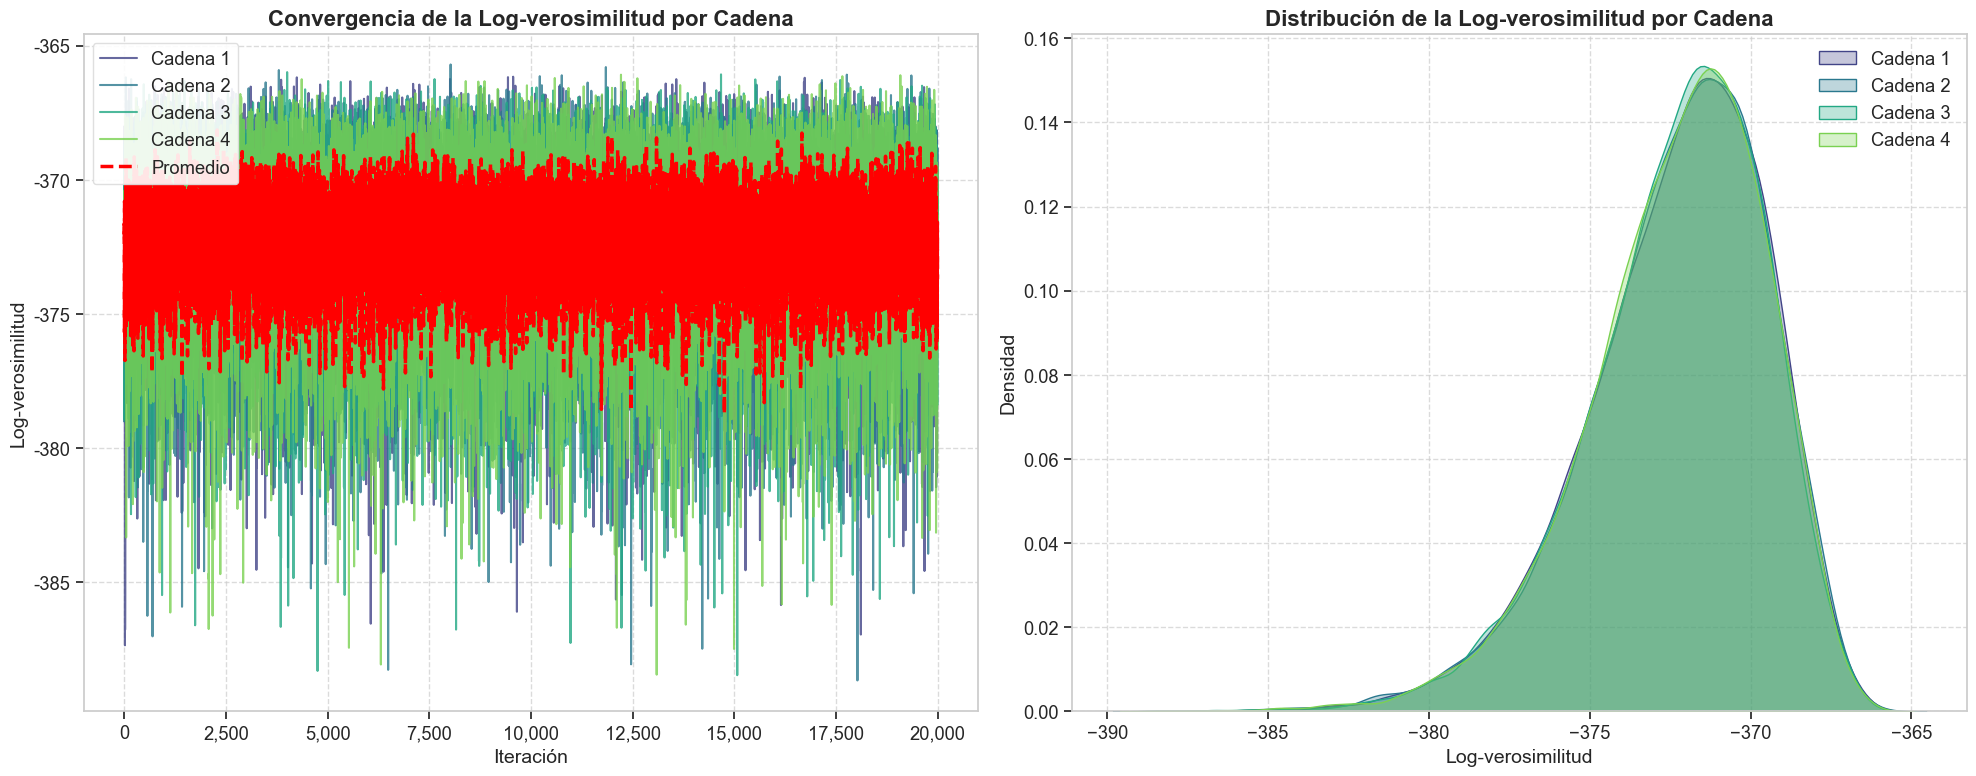

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

log_likelihood = trace.log_likelihood["Y_obs"]
log_posterior = log_likelihood.sum(dim="Y_obs_dim_0")
log_posterior_values = log_posterior.values

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

colors = sns.color_palette("viridis", log_posterior_values.shape[0])

for chain in range(log_posterior_values.shape[0]):
    axes[0].plot(
        np.arange(log_posterior_values.shape[1]), 
        log_posterior_values[chain], 
        label=f"Cadena {chain+1}",
        color=colors[chain],
        linewidth=1.5,
        alpha=0.8
    )

mean_posterior = np.mean(log_posterior_values, axis=0)
axes[0].plot(
    np.arange(mean_posterior.shape[0]), 
    mean_posterior, 
    label="Promedio",
    color="red",
    linewidth=2.5,
    linestyle="--"
)

axes[0].set_xlabel("Iteración", fontsize=14)
axes[0].set_ylabel("Log-verosimilitud", fontsize=14)
axes[0].set_title("Convergencia de la Log-verosimilitud por Cadena", fontsize=16, fontweight='bold')
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

axes[0].grid(True, linestyle='--', alpha=0.7)

axes[0].legend(
    loc='upper left', 
    frameon=True, 
    fancybox=True, 
    framealpha=0.9,
    edgecolor='gainsboro'
)

for chain in range(log_posterior_values.shape[0]):
    sns.kdeplot(
        log_posterior_values[chain],
        ax=axes[1],
        label=f"Cadena {chain+1}",
        color=colors[chain],
        fill=True,
        alpha=0.3
    )

axes[1].set_xlabel("Log-verosimilitud", fontsize=14)
axes[1].set_ylabel("Densidad", fontsize=14)
axes[1].set_title("Distribución de la Log-verosimilitud por Cadena", fontsize=16, fontweight='bold')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ajustes finales
plt.tight_layout()
plt.savefig(f"Log_Post_SBMSIM1.png", dpi=300, bbox_inches="tight")
plt.show()

THETA CONVERGENCE

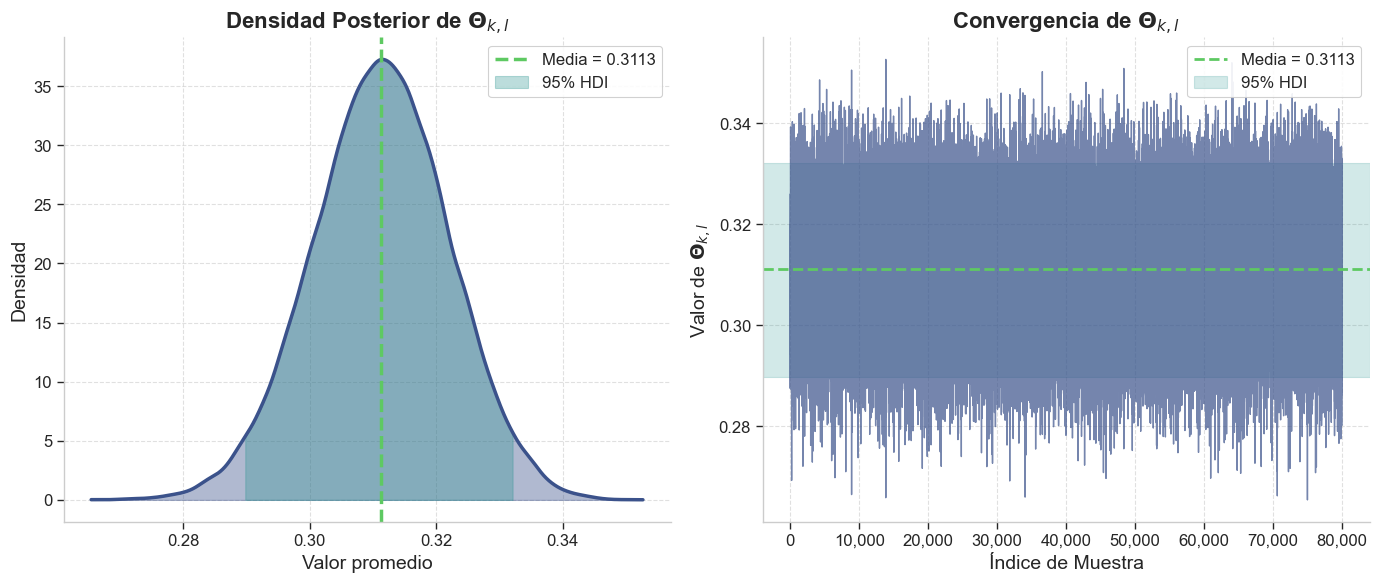

          Estadística      Valor
     Promedio de Mean      0.311
       Promedio de SD      0.011
   Promedio de HDI 3%      0.291
  Promedio de HDI 97%      0.332
Promedio de MCSE Mean      0.000
  Promedio de MCSE SD      0.000
 Promedio de ESS Bulk 144474.000
 Promedio de ESS Tail  62996.000
    Promedio de R hat      1.000


In [11]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.3)
colors = sns.color_palette("viridis", 3)

theta_samples = trace.posterior['Theta_kl'].values 
theta_samples_flattened = theta_samples.reshape(-1, theta_samples.shape[-1])
theta_means_per_sample = theta_samples_flattened.mean(axis=1)

mean_value = theta_means_per_sample.mean()

kde = gaussian_kde(theta_means_per_sample)
x_vals = np.linspace(theta_means_per_sample.min(), theta_means_per_sample.max(), 1000)
y_vals = kde(x_vals)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
fig.patch.set_facecolor('white')

ax[0].plot(x_vals, y_vals, color=colors[0], linewidth=2.5)
ax[0].fill_between(x_vals, y_vals, color=colors[0], alpha=0.4)
ax[0].axvline(mean_value, color=colors[2], linestyle='--', linewidth=2.5, 
            label=f'Media = {mean_value:.4f}')

lower_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 2.5))
upper_idx = np.searchsorted(x_vals, np.percentile(theta_means_per_sample, 97.5))
ax[0].fill_between(x_vals[lower_idx:upper_idx], y_vals[lower_idx:upper_idx], 
                   color=colors[1], alpha=0.3,
                   label='95% HDI')

ax[0].set_title('Densidad Posterior de $\mathbf{\Theta}_{k,l}$', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Valor promedio', fontsize=14)
ax[0].set_ylabel('Densidad', fontsize=14)
ax[0].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[1].plot(theta_means_per_sample, color=colors[0], alpha=0.7, linewidth=1.0)
ax[1].axhline(y=mean_value, color=colors[2], linestyle='--', linewidth=2, 
             label=f'Media = {mean_value:.4f}')

upper_bound = np.percentile(theta_means_per_sample, 97.5)
lower_bound = np.percentile(theta_means_per_sample, 2.5)
ax[1].axhspan(lower_bound, upper_bound, alpha=0.2, color=colors[1], label='95% HDI')

ax[1].set_title('Convergencia de $\mathbf{\Theta}_{k,l}$', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Índice de Muestra', fontsize=14)
ax[1].set_ylabel('Valor de $\mathbf{\Theta}_{k,l}$', fontsize=14)
ax[1].legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=12, loc='upper right')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].tick_params(axis='both', which='major', labelsize=12)

ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

plt.tight_layout()
plt.savefig("convThetaSBM_Sim1.png", dpi=300, bbox_inches="tight")
plt.show()

theta_samples = trace.posterior['Theta_kl'].values  # (chains, draws, dim)
theta_means_per_chain = theta_samples.mean(axis=-1)  # (chains, draws)

theta_means_xr = xr.DataArray(
    theta_means_per_chain,
    dims=["chain", "draw"],
    name="theta_mean"
)
inference_data = az.from_dict(posterior={"theta_mean": theta_means_xr})

summary_df = az.summary(inference_data, var_names=["theta_mean"], hdi_prob=0.94)
# SUMMARY
stats = {
    "Promedio de Mean": summary_df["mean"].values[0],
    "Promedio de SD": summary_df["sd"].values[0],
    "Promedio de HDI 3%": summary_df["hdi_3%"].values[0],
    "Promedio de HDI 97%": summary_df["hdi_97%"].values[0],
    "Promedio de MCSE Mean": summary_df["mcse_mean"].values[0],
    "Promedio de MCSE SD": summary_df["mcse_sd"].values[0],
    "Promedio de ESS Bulk": summary_df["ess_bulk"].values[0],
    "Promedio de ESS Tail": summary_df["ess_tail"].values[0],
    "Promedio de R hat": summary_df["r_hat"].values[0],
}

tabla_estadisticas = pd.DataFrame({
    "Estadística": list(stats.keys()),
    "Valor": [round(v, 4) for v in stats.values()]
})
print(tabla_estadisticas.to_string(index=False))

PRECISION

Generando redes...
Calculando estadísticas de red...
Generando visualizaciones...


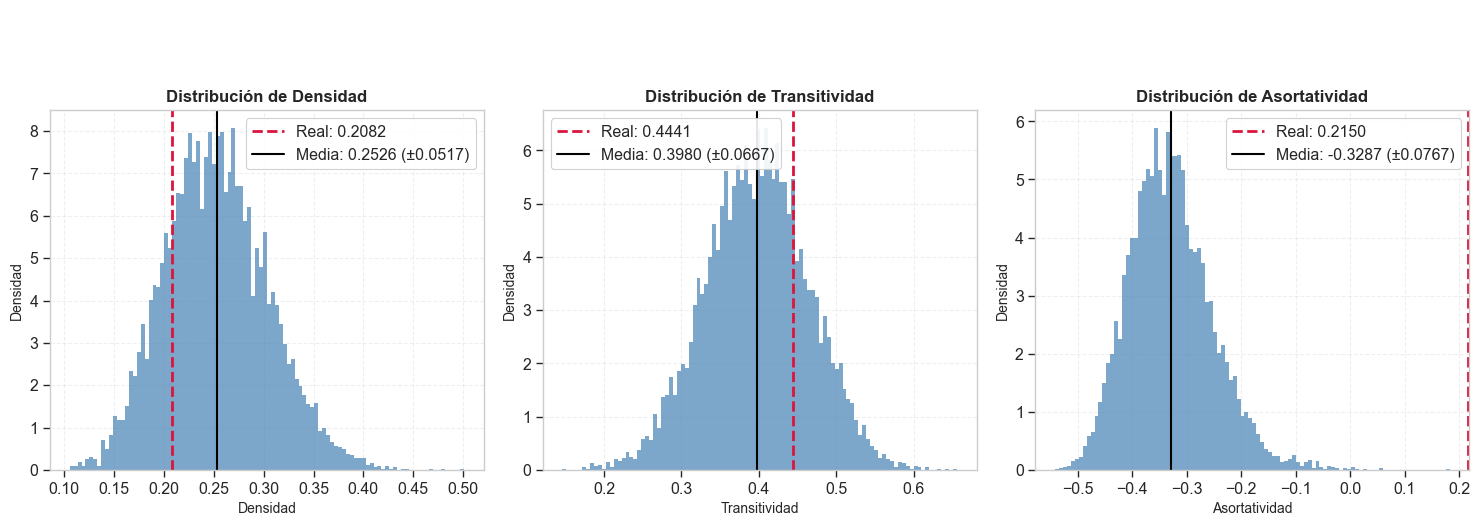


===== RESUMEN DE ESTADÍSTICAS =====

DENSIDAD:
  Real:              0.2082
  Media Simulada:    0.2526
  Desviación Std:    0.0517
  Error Absoluto:    0.0444
  Error Relativo:    21.35%

TRANSITIVIDAD:
  Real:              0.4441
  Media Simulada:    0.3980
  Desviación Std:    0.0667
  Error Absoluto:    0.0461
  Error Relativo:    10.38%

ASORTATIVIDAD:
  Real:              0.2150
  Media Simulada:    -0.3287
  Desviación Std:    0.0767
  Error Absoluto:    0.5437
  Error Relativo:    252.87%


In [13]:
def reconstruct_interaction_matrix(theta_samples: np.ndarray) -> np.ndarray:
    if theta_samples.ndim == 4:
        theta_samples = theta_samples.reshape(-1, theta_samples.shape[2], theta_samples.shape[3])
    return theta_samples


def safe_assortativity(G: nx.Graph) -> float:
    try:
        assort = nx.degree_assortativity_coefficient(G)
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    try:
        nx.set_node_attributes(G, {n: np.random.random() for n in G.nodes()}, 'random_attr')
        assort = nx.attribute_assortativity_coefficient(G, 'random_attr')
        if not np.isnan(assort):
            return assort
    except Exception:
        pass
    
    return 0  


def generate_networks(
    interaction_matrices: np.ndarray, 
    num_nodes: int, 
    num_blocks: int, 
    networks_per_matrix: int = 2000
) -> List[nx.Graph]:

    networks = []
    
    for matrix in interaction_matrices:
        for _ in range(networks_per_matrix):
            block_assignments = np.random.randint(0, num_blocks, size=num_nodes)
            
            G = nx.Graph()
            G.add_nodes_from(range(num_nodes))

            edges = []
            for i in range(num_nodes):
                for j in range(i+1, num_nodes):
                    block_i, block_j = block_assignments[i], block_assignments[j]
                    if np.random.random() < matrix[block_i, block_j]:
                        edges.append((i, j))
            
            G.add_edges_from(edges)
            networks.append(G)
    
    return networks


def compute_network_statistics(networks: List[nx.Graph]) -> Dict[str, List[float]]:
    stats = {
        'densidad': [],
        'transitividad': [],
        'asortatividad': []
    }
    
    for G in networks:

        stats['densidad'].append(nx.density(G))

        try:
            transitivity = nx.transitivity(G)
            stats['transitividad'].append(transitivity if not np.isnan(transitivity) else 0)
        except (nx.NetworkXError, ZeroDivisionError):
            stats['transitividad'].append(0)

        stats['asortatividad'].append(safe_assortativity(G))
    
    return stats


def plot_statistics_comparison(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float], 
    output_file: Optional[str] = "precision_estMSBSIM1.png"
) -> plt.Figure:
 
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    stat_names = ['densidad', 'transitividad', 'asortatividad']
    
    for i, stat_name in enumerate(stat_names):
 
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
     
        posterior_mean = np.mean(valid_stats)
        posterior_std = np.std(valid_stats)

        axes[i].hist(valid_stats, bins=min(100, len(valid_stats)//50 + 10), 
                    density=True, alpha=0.7, color='steelblue')

        axes[i].axvline(real_stats[stat_name], color='crimson', linestyle='--', linewidth=2,
                       label=f'Real: {real_stats[stat_name]:.4f}')

        axes[i].axvline(posterior_mean, color='black', linestyle='-', linewidth=1.5,
                       label=f'Media: {posterior_mean:.4f} (±{posterior_std:.4f})')

        axes[i].set_title(f'Distribución de {stat_name.capitalize()}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel(stat_name.capitalize(), fontsize=10)
        axes[i].set_ylabel('Densidad', fontsize=10)
        axes[i].grid(alpha=0.3, linestyle='--')
        axes[i].legend(loc='best', frameon=True, framealpha=0.9)
    
    plt.suptitle(' ', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig


def summarize_statistics(
    stats: Dict[str, List[float]], 
    real_stats: Dict[str, float]
) -> Dict[str, Dict[str, float]]:
  
    summary = {}
    
    for stat_name in ['densidad', 'transitividad', 'asortatividad']:
        valid_stats = np.array([x for x in stats[stat_name] if not np.isnan(x)])
        
        summary[stat_name] = {
            'real': real_stats[stat_name],
            'media': np.mean(valid_stats),
            'desv_std': np.std(valid_stats),
            'mediana': np.median(valid_stats),
            'error_abs': abs(real_stats[stat_name] - np.mean(valid_stats)),
            'error_rel': abs(real_stats[stat_name] - np.mean(valid_stats)) / (abs(real_stats[stat_name]) + 1e-10) * 100
        }
    
    return summary


def main():
    real_stats = {
        'densidad': 0.2082,
        'transitividad': 0.4441,
        'asortatividad': 0.2150
    }

    theta_samples = trace.posterior['Theta_kl'].values
    interaction_matrices = reconstruct_interaction_matrix(theta_samples)

    print("Generando redes...")
    networks = generate_networks(
        interaction_matrices, 
        num_nodes=50, 
        num_blocks=8, 
        networks_per_matrix=2000
    )

    print("Calculando estadísticas de red...")
    network_stats = compute_network_statistics(networks)

    print("Generando visualizaciones...")
    fig = plot_statistics_comparison(network_stats, real_stats)
    plt.savefig("presicionSBM_Sim1.png", dpi=300, bbox_inches="tight")
    plt.show()

    summary = summarize_statistics(network_stats, real_stats)
    
    print("\n===== RESUMEN DE ESTADÍSTICAS =====")
    for stat_name, values in summary.items():
        print(f"\n{stat_name.upper()}:")
        print(f"  Real:              {values['real']:.4f}")
        print(f"  Media Simulada:    {values['media']:.4f}")
        print(f"  Desviación Std:    {values['desv_std']:.4f}")
        print(f"  Error Absoluto:    {values['error_abs']:.4f}")
        print(f"  Error Relativo:    {values['error_rel']:.2f}%")


if __name__ == "__main__":
    main()

LIKELIHOOD DIAGNOSTIC CONVERGENCE

In [14]:
def calculate_manual_rhat(chains):
    """Calcula R-hat manualmente"""
    n_chains, n_samples = chains.shape

    chain_means = np.mean(chains, axis=1)
    overall_mean = np.mean(chain_means)

    B = n_samples * np.sum((chain_means - overall_mean)**2) / (n_chains - 1)

    chain_vars = np.var(chains, axis=1, ddof=1)
    W = np.mean(chain_vars)

    var_est = ((n_samples - 1) / n_samples) * W + B / n_samples

    r_hat = np.sqrt(var_est / W)
    return r_hat

def calculate_ess_simple(chains):
    n_chains, n_samples = chains.shape
    mean_autocorr = 0
    for chain in chains:
        norm_chain = (chain - np.mean(chain))
        autocorr = np.sum(norm_chain[1:] * norm_chain[:-1]) / np.sum(norm_chain**2)
        mean_autocorr += autocorr / n_chains

    ess = n_chains * n_samples * (1 - mean_autocorr) / (1 + mean_autocorr)
    return ess

def simple_diagnostics(log_posterior_values):
    r_hat = calculate_manual_rhat(log_posterior_values)
    ess = calculate_ess_simple(log_posterior_values)
    
    print("\n===== DIAGNÓSTICOS DE CONVERGENCIA SIMPLIFICADOS =====")
    print(f"ESS estimado: {ess:.2f}")
    print(f"R-hat: {r_hat:.4f}")

    print("\n===== INTERPRETACIÓN =====")
    if ess < 400:
        print("⚠️ El ESS es bajo. Considere aumentar el número de iteraciones.")
    else:
        print("✓ El ESS es adecuado.")
        
    if r_hat > 1.01:
        print("⚠️ El R-hat es mayor a 1.01. Las cadenas no han convergido completamente.")
    else:
        print("✓ El valor de R-hat indica buena convergencia de las cadenas.")
    
    return ess, r_hat

In [15]:
simple_diagnostics(log_posterior_values)


===== DIAGNÓSTICOS DE CONVERGENCIA SIMPLIFICADOS =====
ESS estimado: 32482.67
R-hat: 1.0000

===== INTERPRETACIÓN =====
✓ El ESS es adecuado.
✓ El valor de R-hat indica buena convergencia de las cadenas.


(32482.668122036815, 0.9999995876647206)

PPP

In [35]:
def calculate_ppp_values(
    trace: az.InferenceData,
    real_network: nx.Graph,
    num_nodes: int,
    num_blocks: int,
    n_samples: int = 500,
    networks_per_sample: int = 4  #
) -> Dict[str, Any]:
   
    real_stats = compute_network_statistic(real_network)
    
    theta_samples = trace.posterior['Theta_kl'].values
    interaction_matrices = reconstruct_interaction_matrix(theta_samples)
    if len(interaction_matrices) > n_samples:
        indices = np.random.choice(len(interaction_matrices), n_samples, replace=False)
        interaction_matrices = interaction_matrices[indices]
    
    simulated_stats = {
        'densidad': [],
        'transitividad': [],
        'asortatividad': []
    }
    
    print(f"Generando {len(interaction_matrices) * networks_per_sample} redes simuladas para PPP...")
    for matrix in tqdm(interaction_matrices):
        for _ in range(networks_per_sample):  # Generar múltiples redes por matriz
            G_sim = generate_network_from_matrix(matrix, num_nodes, num_blocks)
            stats = compute_network_statistic(G_sim)
            
            for key, value in stats.items():
                simulated_stats[key].append(value)
    
    ppp_values = {}
    ppp_summary = {}
    
    for stat_name in real_stats.keys():
        real_value = real_stats[stat_name]
        sim_values = np.array(simulated_stats[stat_name])

        sim_values = sim_values[~np.isnan(sim_values)]

        ppp = np.mean(sim_values >= real_value)

        ppp_values[stat_name] = ppp
        ppp_summary[stat_name] = {
            'ppp': ppp,
            'real': real_value,
            'sim_mean': np.mean(sim_values),
            'sim_std': np.std(sim_values),
            'sim_5%': np.percentile(sim_values, 5),
            'sim_95%': np.percentile(sim_values, 95)
        }
    
    return {
        'ppp_values': ppp_values,
        'ppp_summary': ppp_summary,
        'simulated_stats': simulated_stats,
        'real_stats': real_stats
    }


def plot_ppp_results(ppp_results: Dict[str, Any], output_file: Optional[str] = "ppp_results.png") -> plt.Figure:

    real_stats = ppp_results['real_stats']
    simulated_stats = ppp_results['simulated_stats']
    ppp_values = ppp_results['ppp_values']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    stat_names = ['densidad', 'transitividad', 'asortatividad']
    
    for i, stat_name in enumerate(stat_names):
        valid_stats = np.array([x for x in simulated_stats[stat_name] if not np.isnan(x)])

        axes[i].hist(valid_stats, bins=min(100, len(valid_stats)//50 + 10), 
                    density=True, alpha=0.7, color='steelblue')
        
        axes[i].axvline(real_stats[stat_name], color='crimson', linestyle='--', linewidth=2,
                       label=f'Real: {real_stats[stat_name]:.4f}')

        posterior_mean = np.mean(valid_stats)
        posterior_std = np.std(valid_stats)
        axes[i].axvline(posterior_mean, color='black', linestyle='-', linewidth=1.5,
                       label=f'Media Sim: {posterior_mean:.4f} (±{posterior_std:.4f})')

        ci_lower = np.percentile(valid_stats, 5)
        ci_upper = np.percentile(valid_stats, 95)
        axes[i].axvspan(ci_lower, ci_upper, alpha=0.2, color='gray', 
                       label=f'IC 90%: [{ci_lower:.4f}, {ci_upper:.4f}]')
        
        error_abs = abs(real_stats[stat_name] - posterior_mean)
        error_rel = error_abs / (abs(real_stats[stat_name]) + 1e-10) * 100
        error_text = f'Error Abs: {error_abs:.4f}\nError Rel: {error_rel:.2f}%'
        axes[i].text(0.05, 0.85, error_text, transform=axes[i].transAxes, 
                    fontsize=10, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

        ppp_text = f'PPP = {ppp_values[stat_name]:.3f}'
        if ppp_values[stat_name] < 0.05 or ppp_values[stat_name] > 0.95:
            ppp_text += ' (!)'
            
        axes[i].text(0.05, 0.95, ppp_text, transform=axes[i].transAxes, 
                    fontsize=12, fontweight='bold', 
                    bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

        axes[i].set_title(f'Distribución Posterior Predictiva: {stat_name.capitalize()}', 
                         fontsize=12, fontweight='bold')
        axes[i].set_xlabel(stat_name.capitalize(), fontsize=10)
        axes[i].set_ylabel('Densidad', fontsize=10)
        axes[i].grid(alpha=0.3, linestyle='--')
        axes[i].legend(loc='upper right', frameon=True, framealpha=0.9)
    
    plt.suptitle('Verificación Posterior Predictiva (PPP)', fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    return fig


def print_ppp_summary(ppp_results: Dict[str, Any]):

    summary = ppp_results['ppp_summary']
    
    print("\n===== RESUMEN DE VERIFICACIÓN POSTERIOR PREDICTIVA (PPP) =====")
    
    for stat_name, values in summary.items():
        real_value = values['real']
        sim_mean = values['sim_mean']
        sim_std = values['sim_std']
        
        # Calcular error absoluto y relativo (como en el código original)
        error_abs = abs(real_value - sim_mean)
        error_rel = error_abs / (abs(real_value) + 1e-10) * 100
        
        print(f"\n{stat_name.upper()}:")
        print(f"  Valor Real:           {real_value:.4f}")
        print(f"  Media Simulada:       {sim_mean:.4f}")
        print(f"  Desviación Estándar:  {sim_std:.4f}")
        print(f"  Error Absoluto:       {error_abs:.4f}")
        print(f"  Error Relativo:       {error_rel:.2f}%")
        print(f"  IC 90%:               [{values['sim_5%']:.4f}, {values['sim_95%']:.4f}]")
        print(f"  Valor PPP:            {values['ppp']:.4f}")
        
        # Interpretación del PPP
        if values['ppp'] < 0.05:
            print("  Interpretación:       ¡DISCREPANCIA! El modelo tiende a generar valores MENORES que los observados")
        elif values['ppp'] > 0.95:
            print("  Interpretación:       ¡DISCREPANCIA! El modelo tiende a generar valores MAYORES que los observados")
        else:
            print("  Interpretación:       El modelo representa adecuadamente esta estadística")


def create_adjacency_matrix_from_edgelist(edgelist, num_nodes):

    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for i, j in edgelist:
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1  
    return adj_matrix


def main(trace, data_matrix, num_nodes, num_blocks):
    real_network = nx.from_numpy_array(data_matrix)
  
    print("Calculando valores PPP...")
    ppp_results = calculate_ppp_values(
        trace=trace,
        real_network=real_network,
        num_nodes=num_nodes,
        num_blocks=num_blocks,
        n_samples=500,       
        networks_per_sample=4  
    )
    
    print_ppp_summary(ppp_results)

    print("Generando visualizaciones de PPP...")
    fig = plot_ppp_results(ppp_results, output_file="ppp_network_statistics.png")
    plt.savefig("ppp_network_statistics.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    return ppp_results

def run_ppp_analysis(trace, data_matrix, num_nodes, num_blocks):
 
    print("\n===== INICIANDO ANÁLISIS DE VERIFICACIÓN POSTERIOR PREDICTIVA =====")
    print(f"Número de nodos: {num_nodes}")
    print(f"Número de bloques: {num_blocks}")

    ppp_results = main(trace, data_matrix, num_nodes, num_blocks)
    
    print("\n===== ANÁLISIS PPP COMPLETADO =====")
    print("Los resultados se han guardado en 'ppp_network_statistics.png'")
    
    return ppp_results


if __name__ == "__main__":

    pass

Calculando valores PPP...
Generando 16 redes simuladas para PPP...


100%|██████████| 4/4 [00:00<00:00, 96.96it/s]


===== RESUMEN DE VERIFICACIÓN POSTERIOR PREDICTIVA (PPP) =====

DENSIDAD:
  Valor Real:           0.2082
  Media Simulada:       0.2470
  Desviación Estándar:  0.0443
  Error Absoluto:       0.0389
  Error Relativo:       18.68%
  IC 90%:               [0.1798, 0.3043]
  Valor PPP:            0.7500
  Interpretación:       El modelo representa adecuadamente esta estadística

TRANSITIVIDAD:
  Valor Real:           0.4441
  Media Simulada:       0.3950
  Desviación Estándar:  0.0617
  Error Absoluto:       0.0491
  Error Relativo:       11.05%
  IC 90%:               [0.3037, 0.4805]
  Valor PPP:            0.2500
  Interpretación:       El modelo representa adecuadamente esta estadística

ASORTATIVIDAD:
  Valor Real:           0.2150
  Media Simulada:       -0.3372
  Desviación Estándar:  0.0827
  Error Absoluto:       0.5522
  Error Relativo:       256.80%
  IC 90%:               [-0.4422, -0.2139]
  Valor PPP:            0.0000
  Interpretación:       ¡DISCREPANCIA! El modelo tiende 

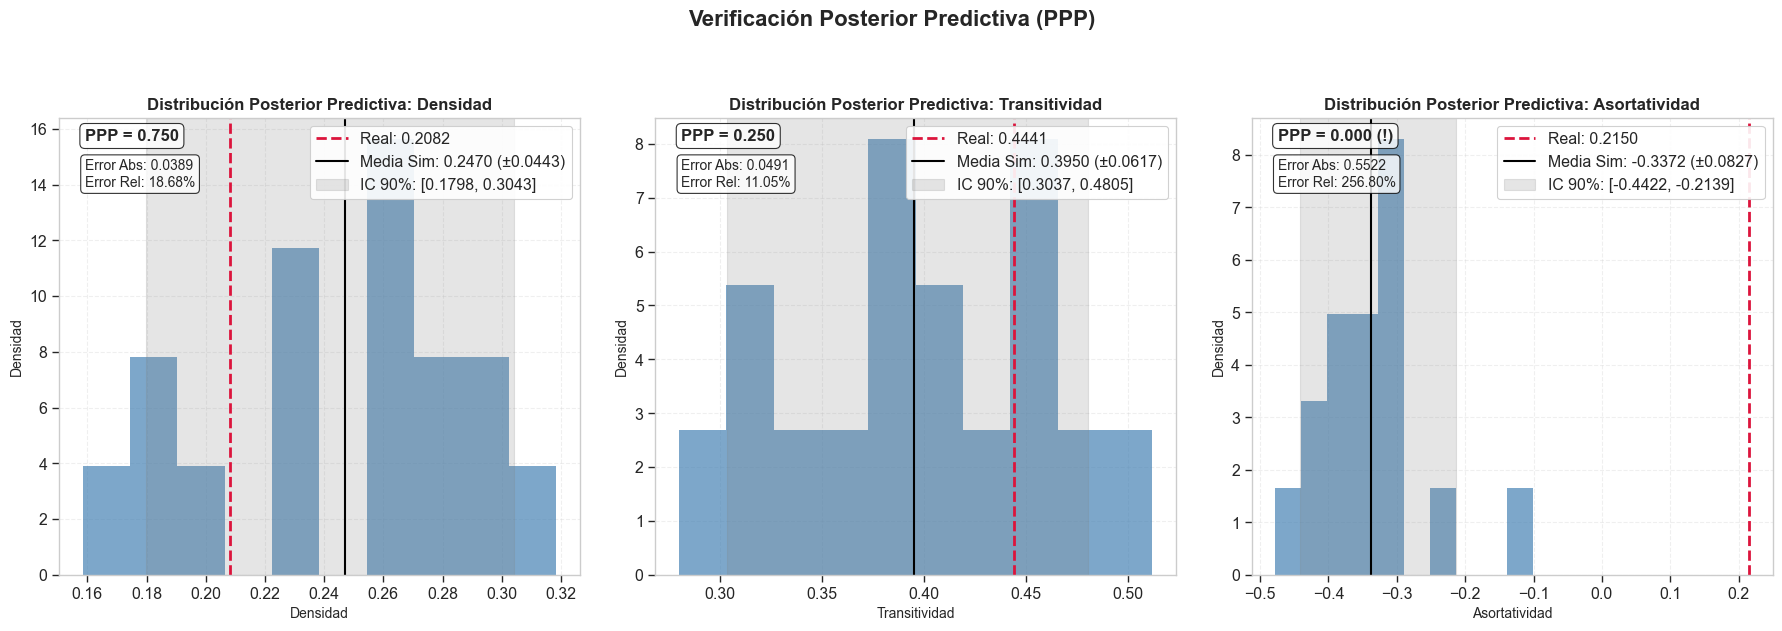

In [37]:
ppp_results = main(trace, data_matrix, num_nodes, num_blocks)